## Assignment 04b: Sleeping habits

As a data scientist you will work with ordinal or categorical data as well. What are good methods to visualize such data? What are proper statistics to use? What needs to be done in the data preparation steps to conduct certain analysis. During this week we will work with data from a sleeping study. This dataset is not mandatory. You are encouraged to use data from your project when possible. 

Keywords: statistics, categorical data, ordinal data, survey-based study of the sleeping, exploratory data analysis, normalization, hypothesis testing, p-value


More to read:
- https://fennaf.gitbook.io/bfvm22prog1/

https://machinelearningmastery.com/statistical-hypothesis-tests-in-python-cheat-sheet/
There are a number of cheatsheets and tutorials on the internet. The next overview is a compact overview of tutorials
- https://www.kaggle.com/hamelg/python-for-data-21-descriptive-statistics
- https://www.kaggle.com/hamelg/python-for-data-22-probability-distributions
- https://www.kaggle.com/hamelg/python-for-data-23-confidence-intervals
- https://www.kaggle.com/hamelg/python-for-data-24-hypothesis-testing
- https://www.kaggle.com/hamelg/python-for-data-25-chi-squared-tests
- https://www.kaggle.com/hamelg/python-for-data-26-anova/notebook
- https://www.kaggle.com/hamelg/python-for-data-27-linear-regression


You will learn about analysing data with pandas and numpy and you will learn to visualize with bokeh. Concretely, you will preprocess the Sleep Study data in an appropiate format in order to conduct statistical and visual analysis. 

Learning objectives
- Conduct exploratory data analysis for categarical data
- Provide statistical evidence of factor effect
- Maintain development environment 
- Apply coding standards and FAIR principles

Please add topics you want to learn here: https://padlet.com/ffeenstra1/z9duo25d39dcgezz


## About the data

The data is collected from a survey-based study of the sleeping habits of individuals within the US. 

Below is a description of each of the variables contained within the dataset.

- Enough = Do you think that you get enough sleep?
- Hours = On average, how many hours of sleep do you get on a weeknight?
- PhoneReach = Do you sleep with your phone within arms reach?
- PhoneTime = Do you use your phone within 30 minutes of falling asleep?
- Tired = On a scale from 1 to 5, how tired are you throughout the day? (1 being not tired, 5 being very tired)
- Breakfast = Do you typically eat breakfast?

The two research questions you should answer in this assignment are:
1. Is there a differences in Hours sleep caused by having breakfast (yes, no)?
2. Is there a differences in Hours sleep caused by having breakfast and the tireness (score)


The assignment consists of 6 parts:

- [part 1: load the data](#0)
- [part 2: data inspection](#1)
- [part 3: check assumptions](#2)
   - [check normality 3.1](#ex-31)
   - [check equal variance 3.2](#ex-32)
- [part 4: prepare the data](#3)
- [part 5: answer the research question](#4)
- [part 6: enhanced plotting](#5)

Part 1 till 5 are mandatory, part 6 is optional (bonus)
Mind you that you cannot copy code without referencing the code. If you copy code you need to be able to explain your code verbally and you will not get the full score. 


**NOTE If your project data is suitable you can use that data instead of the given data**

## ANOVA

Analysis of variance (ANOVA) compares the variances between groups versus within groups. It basically determines whether the differences between groups is larger than the differences within a group (the noise). 
A graph picturing this is as follow: https://link.springer.com/article/10.1007/s00424-019-02300-4/figures/2


In ANOVA, the dependent variable must be a continuous (interval or ratio) level of measurement. For instance Glucose level. The independent variables in ANOVA must be categorical (nominal or ordinal) variables. For instance trial category, time of day (AM versus PM) or time of trial (different categories). Like the t-test, ANOVA is also a parametric test and has some assumptions. ANOVA assumes that the data is normally distributed.  The ANOVA also assumes homogeneity of variance, which means that the variance among the groups should be approximately equal. ANOVA also assumes that the observations are independent of each other. 

A one-way ANOVA has just one independent variable. A two-way ANOVA (are also called factorial ANOVA) refers to an ANOVA using two independent variables. For research question 1 we can use the one-way ANOVA, for research question two we can use two-way ANOVA. But first we need to check the assumptions. 

If your data is not normally distributed you might want to look for an alternative. See also https://www.statisticshowto.com/probability-and-statistics/statistics-definitions/parametric-and-non-parametric-data/


---

<a name='0'></a>
## Part 1: Load the data (10 pt)

load the `sleep.csv` data. 
Preferably we read the data not with a hard coded data path but using a config file. See https://fennaf.gitbook.io/bfvm22prog1/data-processing/configuration-files/yaml. Get yourself familiar with the data. Answer the following questions.

1. What is the percentage missing data?
2. Considering the research question, what is the dependent variable and what are the indepent variables? Are they of the correct datatype? 

In [58]:
import yaml
import pandas as pd
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.layouts import gridplot
from bokeh.models import (BasicTicker, ColorBar, ColumnDataSource,
                          LinearColorMapper, PrintfTickFormatter, Span)
from bokeh.transform import transform
from bokeh.palettes import PuBuGn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
from scipy.stats import norm, levene
import statsmodels.api as sm
from statsmodels.formula.api import ols

output_notebook()

Loading BokehJS ...

In [59]:
def get_config():
    with open("config.yaml", 'r') as stream:
        config = yaml.safe_load(stream)
    return config
config = get_config()
db = config['db']

In [60]:
try:
    data = pd.read_csv(db + 'sleep.csv')
except FileNotFoundError:
    print('No such file')

In [61]:
display(data.head())
data.info()

,Enough,Hours,PhoneReach,PhoneTime,Tired,Breakfast
0,Yes,8.0,Yes,Yes,3,Yes
1,No,6.0,Yes,Yes,3,No
2,Yes,6.0,Yes,Yes,2,Yes
3,No,7.0,Yes,Yes,4,No
4,No,7.0,Yes,Yes,2,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Enough      104 non-null    object 
 1   Hours       102 non-null    float64
 2   PhoneReach  104 non-null    object 
 3   PhoneTime   104 non-null    object 
 4   Tired       104 non-null    int64  
 5   Breakfast   104 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 5.0+ KB


In [62]:
#code printing percentage missing data
print('Percent of missing data: {:.2f}%'.format(data['Hours'].isna().sum()*100 / len(data)))
data[data['Hours'].isna()]

Percent of missing data: 1.92%


,Enough,Hours,PhoneReach,PhoneTime,Tired,Breakfast
65,No,NaN,Yes,No,3,Yes
91,Yes,NaN,No,Yes,2,Yes


In [63]:
data = data.drop(data[data['Hours'].isna()].index)

array([[<AxesSubplot:title={'center':'Hours'}>]], dtype=object)

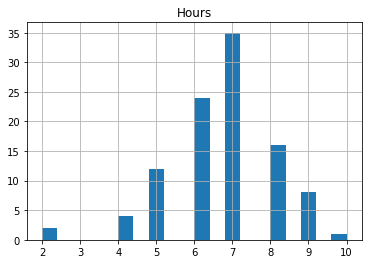

In [64]:
# visual representation of hours range
data.hist('Hours', bins = 20)

Information on Enough, PhoneReach, PhoneTime, Tired and Breakfast are categorical variables. 
Since dependent variable is a continuous one, then 'Hours' is the dependent. And the columns with categorical values are independent.

The data in the table is of correct data type.

---

<a name='1'></a>
## Part 2: Inspect the data (30 pt)

Inspect the data practically. Get an idea about how well the variable categories are ballanced. Are the values of a variable equally divided? What is the mean value of the dependent variable? Are there correlations amongs the variables?


<ul>
<li>Create some meaninful overviews such as variable value counts</li>
<li>Create a scatter plot ploting the relation between being tired and hours of sleep with different colors for Breakfast</li>
    <li>Print some basic statistics about the target (mean, standard deviation)</li>
    <li>Create a heatmap to check for correlations among variables. </li>

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
    <ul><li>the gitbook has a bokeh heatmap example</li></ul>
</details>
</ul>

In [65]:
#code your answer to the value counts and distribution plots here
for col in data.columns:
    print(f'Number of unique values for column {col}')
    display(data[col].value_counts().reset_index())

Number of unique values for column Enough


,index,Enough
0,No,67
1,Yes,35


Number of unique values for column Hours


,index,Hours
0,7.0,35
1,6.0,24
2,8.0,16
3,5.0,12
4,9.0,8
5,4.0,4
6,2.0,2
7,10.0,1


Number of unique values for column PhoneReach


,index,PhoneReach
0,Yes,71
1,No,31


Number of unique values for column PhoneTime


,index,PhoneTime
0,Yes,83
1,No,19


Number of unique values for column Tired


,index,Tired
0,3,39
1,2,26
2,4,23
3,5,10
4,1,4


Number of unique values for column Breakfast


,index,Breakfast
0,Yes,61
1,No,41


In [66]:
#code for the scatter plot here
from bokeh.transform import factor_cmap
index_cmap = factor_cmap('Breakfast', palette=['red', 'blue'], factors=sorted(data.Breakfast.unique()))
p = figure()
#p.scatter(source=data, x='Tired', y='Hours', fill_alpha=0.6, size=8, fill_color=index_cmap, legend='Breakfast')
for i in data.Breakfast.unique():
    data_filtered=data.loc[(data.Breakfast==i)]
    p.scatter(source=data_filtered, x='Tired', y='Hours',fill_alpha=0.6, fill_color=index_cmap,size=8,legend='Breakfast')

p.xaxis.axis_label = 'Tired'
p.yaxis.axis_label = 'Hours'
p.legend.location = "top_left"
p.legend.click_policy="hide"
show(p)

ERROR:bokeh.core.validation.check:E-1006 (NON_MATCHING_DATA_SOURCES_ON_LEGEND_ITEM_RENDERERS): LegendItem.label is a field, but renderer data sources don't match: LegendItem(id='3224', ...)


There is some slight correlation between tiredness and hours asleep (the less sleep duration the more tired), but there is no visible effect of having a breakfast or not.

In [67]:
#code your answer to the target statistics here
data['Hours'].describe()

count    102.000000
mean       6.656863
std        1.417676
min        2.000000
25%        6.000000
50%        7.000000
75%        7.000000
max       10.000000
Name: Hours, dtype: float64

<AxesSubplot:>

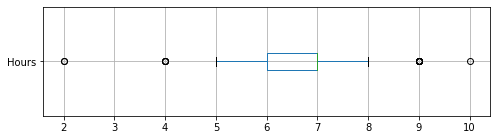

In [68]:
data.boxplot('Hours', vert=False, figsize=(8, 2))

In [69]:
print('Average of hours asleep: {:.1f}'.format(data['Hours'].mean()))

Average of hours asleep: 6.7


In [70]:
#code your answer for the heatmap here and briefly state your finding
# rewriting categorical values, 'yes' and 'no', to binomial 1 and 0
for col in data.columns:
    if data[col].dtype == object:
        data[col] = data[col].map({'Yes': 1, 'No': 0})
    
data.head()

,Enough,Hours,PhoneReach,PhoneTime,Tired,Breakfast
0,1,8.0,1,1,3,1
1,0,6.0,1,1,3,0
2,1,6.0,1,1,2,1
3,0,7.0,1,1,4,0
4,0,7.0,1,1,2,1


In [71]:
data_corr = data.corr().abs() #create a correlation matrix
y_range = (list(reversed(data_corr.columns)))
x_range = (list(data_corr.index))
data_corr

,Enough,Hours,PhoneReach,PhoneTime,Tired,Breakfast
Enough,1.000000,0.380740,0.061183,0.025481,0.410416,0.129246
Hours,0.380740,1.000000,0.054957,0.151378,0.191913,0.225818
PhoneReach,0.061183,0.054957,1.000000,0.176592,0.089936,0.237404
PhoneTime,0.025481,0.151378,0.176592,1.000000,0.032974,0.018631
Tired,0.410416,0.191913,0.089936,0.032974,1.000000,0.244963
Breakfast,0.129246,0.225818,0.237404,0.018631,0.244963,1.000000


In [72]:
#reshape this to be used for the heatmap plot
data_corr_obj = pd.DataFrame(data_corr.stack(), columns=['r']).reset_index()
data_corr_obj

,level_0,level_1,r
0,Enough,Enough,1.000000
1,Enough,Hours,0.380740
2,Enough,PhoneReach,0.061183
3,Enough,PhoneTime,0.025481
4,Enough,Tired,0.410416
5,Enough,Breakfast,0.129246
6,Hours,Enough,0.380740
7,Hours,Hours,1.000000
8,Hours,PhoneReach,0.054957
9,Hours,PhoneTime,0.151378


In [73]:
source = ColumnDataSource(data_corr_obj)

#create colormapper 
mapper = LinearColorMapper(palette=PuBuGn[9], low=data_corr_obj.r.min(), high=data_corr_obj.r.max())

#create plot
p = figure(title="Sleep parameters correlation", plot_width=500, plot_height=450,
           x_range=x_range, y_range=y_range, x_axis_location="above", toolbar_location=None)

#use mapper to fill the rectangles in the plot
p.rect(x="level_0", y="level_1", width=1, height=1, source=source,
       line_color=None, fill_color=transform('r', mapper))

#create and add colorbar to the right
color_bar = ColorBar(color_mapper=mapper, location=(0, 0),
                     ticker=BasicTicker(desired_num_ticks=len(x_range)), 
                     formatter=PrintfTickFormatter(format="%.1f"))
p.add_layout(color_bar, 'right')

#draw axis
p.axis.axis_line_color = None
p.axis.major_tick_line_color = None
p.axis.major_label_text_font_size = "10px"
p.axis.major_label_standoff = 0
p.xaxis.major_label_orientation = 1.0

#show
show(p)

The highest correlation (0.4) seems to be between 'Hours' and 'Enough' and between 'Tired' and 'Enough'.

---

<a name='2'></a>
## Part 3: Check Assumptions

Before we answer the research question with ANOVA we need to check the following assumptions:

1. ANOVA assumes that the dependent variable is normaly distributed
2. ANOVA also assumes homogeneity of variance
3. ANOVA also assumes that the observations are independent of each other. Most of the time we need domain knowledge and experiment setup descriptions to estimate this assumption

We are going to do this graphically and statistically. 

<a name='ex-31'></a>
### Check normality (10 pt)

<ul><li>
Plot the distribution of the dependent variable. Add a vertical line at the position of the average. Add a vertical line for the robuust estimation. Add the normal distribution line to the plot. Comment on the normallity of the data. Do you want the full points? Plot with bokeh!</li>

<li>Use a Shapiro-Wilk Test or an Anderson-Darling test to check statistically</li></ul>


<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
    <ul><li>check the code of lesson 1 DS1 bayesian statistics</li>
        <li>heart_failure case of gitbook uses bokeh histograms</li>
</ul>
</details>

/Users/dilyagrafova/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Hours', ylabel='Density'>

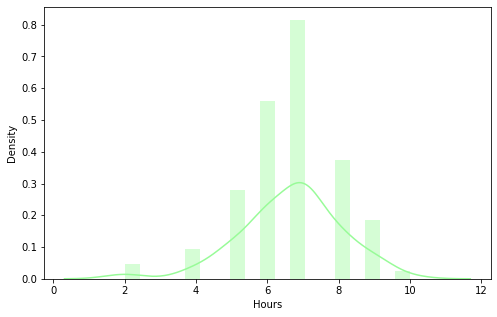

In [74]:
# histogram with seaborn library
plt.figure(figsize = (8,5))
sns.distplot(data['Hours'], color='palegreen')

In [75]:
hist, edges = np.histogram(data['Hours'], 
                           bins = 15,
                           density=True)

p = figure(plot_height = 600, plot_width = 600, 
           title = 'Histogram of Hours of Sleep',
           x_axis_label = 'Hours (h)', 
           y_axis_label = 'Number of records')

p.quad(bottom=0, top=hist, 
       left=edges[:-1], right=edges[1:], 
       fill_color='green', line_color="white", alpha=0.4)


#vertical line at the position of the average
mu = data['Hours'].mean()
p.line([mu, mu], [0, 1], legend_label="Average", line_dash='dashed', line_color="#009E73")

#Add a vertical line for the robust estimation 
mu_R = data['Hours'].median()
p.line([mu_R, mu_R], [0, 1], legend_label="Robust estimate", line_dash='dashed', line_color="#C58940")

#Add the normal distribution line to the plot
x = np.linspace(np.min(data['Hours']), np.max(data['Hours']), 501)
s = np.std(data['Hours'], ddof=1)
rv = np.array([norm.pdf(xi, loc = mu, scale = s) for xi in x])
p.line(x, rv, line_width=1, line_color="navy", legend_label="Probability Density Function")


# Show the plot
show(p)

In [76]:
# Shapiro-Wilk test to check if the distribution is normal
results = st.shapiro(data['Hours'])
p_value = results[1]
alpha = 0.05
print('p-value: ', p_value)

if p_value < alpha:
    print('Not a normal distribution')
else:
    print('Distribution is normal')

p-value:  7.15833084541373e-05
Not a normal distribution


In [77]:
#check for distribution type without outlier
data_filtered = data[data['Hours'] > 2]
results = st.shapiro(data_filtered['Hours'])
p_value = results[1]
alpha = 0.05
print('p-value: ', p_value)

if p_value < alpha:
    print('Not a normal distribution')
else:
    print('Distribution is normal')

p-value:  0.00029438629280775785
Not a normal distribution


In [78]:
hist, edges = np.histogram(data_filtered['Hours'], 
                           bins = 15,
                           density=True)

p = figure(plot_height = 600, plot_width = 600, 
           title = 'Histogram of Hours of Sleep',
           x_axis_label = 'Hours (h)', 
           y_axis_label = 'Number of records')

p.quad(bottom=0, top=hist, 
       left=edges[:-1], right=edges[1:], 
       fill_color='green', line_color="white", alpha=0.4)


#vertical line at the position of the average
mu = data_filtered['Hours'].mean()
p.line([mu, mu], [0, 1], legend_label="Average", line_dash='dashed', line_color="#009E73")

#Add a vertical line for the robust estimation 
mu_R = data_filtered['Hours'].median()
p.line([mu_R, mu_R], [0, 1], legend_label="Robust estimate", line_dash='dashed', line_color="#C58940")

#Add the normal distribution line to the plot
x = np.linspace(np.min(data_filtered['Hours']), np.max(data_filtered['Hours']), 501)
s = np.std(data_filtered['Hours'], ddof=1)
rv = np.array([norm.pdf(xi, loc = mu, scale = s) for xi in x])
p.line(x, rv, line_width=1, line_color="navy", legend_label="Probability Density Function")


# Show the plot
show(p)

The distribution for hours asleep was checked both visually and statistically. Comparing normal distribution to experimental frequency distribution shows us that our value are far from normal distribution. Shapiro-Wilk test confirms histogram results: p-value 7.15e-5 is way smaller than 0.05, thus rejecting the hypothesis of distribution being normal.  
If we delete outlier, 2 hours of sleep, we will get closer to the normal distribution (p-value will be 2.9e-4), but still it won't be normally distributed.


<a name='ex-32'></a>
### Check homogeneity of variance (20 pt)

<ul><li>
Use boxplots for the check of homoegeneity of variance. Do you want the full points? Plot with bokeh!</li>

<li>Use a Levene’s & Bartlett’s Test of Equality (Homogeneity) of Variance to test equal variance statistically</li><ul>

<AxesSubplot:xlabel='Tired', ylabel='Hours'>

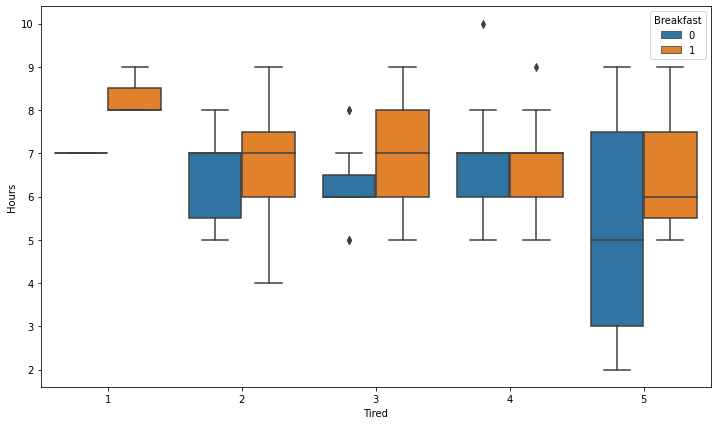

In [79]:
# boxplot on hours asleep based on tiredness and having breakfast
plt.figure(figsize = (12,7))
sns.boxplot(x='Tired', y='Hours', hue='Breakfast', data=data)

<AxesSubplot:xlabel='Breakfast', ylabel='Hours'>

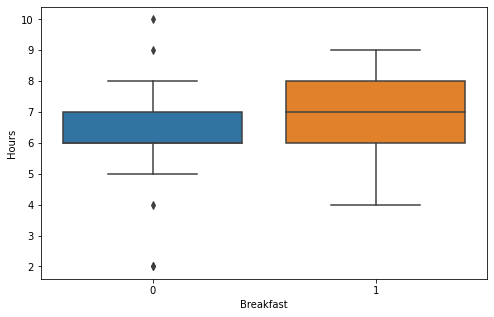

In [80]:
# your code to plot here
#boxplot for data grouped by Breakfast
plt.figure(figsize = (8,5))
sns.boxplot(x='Breakfast', y='Hours', data=data)

In [81]:
data['Breakfast'].value_counts()

1    61
0    41
Name: Breakfast, dtype: int64

In [82]:
# your code for the statistical test here
#Levene's test for data grouped by Breakfast
w_stats, p_value = levene(data[data['Breakfast']==0]['Hours'],data[data['Breakfast']==1]['Hours'], center ='mean')
print('p-value:', p_value) 

if p_value > alpha :
  print("We do not reject the null hypothesis, stating that the variance among groups is equal")
else:
  print("Reject the Null Hypothesis, stating that the variance among groups is equal")

p-value: 0.29695502343069974
We do not reject the null hypothesis, stating that the variance among groups is equal


In [83]:
#Bartlett's test for data grouped by Breakfast
st.bartlett(data[data['Breakfast']==0]['Hours'],data[data['Breakfast']==1]['Hours'])

BartlettResult(statistic=1.937289880736242, pvalue=0.16396309698862105)

We divided our data in two groups, those who had breakfast and who did not. However, the two groups differ size-wise. People who had breakfast have more sleep variance. The median for both groups is pretty much the same.  
Statistical tests (Levene's and Bartlett's) confirmed taht there are not enough evidence that the groups have different variances.  
However, Bartlett's test is sensitive to deviations from normality. By verifying results to results from Levene's test we can be sure that they are not false positive. 

---

<a name='3'></a>
## Part 4: Prepare your data (10 pt)

Create a dataframe with equal samplesize. Make three categories for tireness 1-2 = no, 3 = maybe, 4-5 = yes

In [84]:
#your solution here
data['Tired'] = data['Tired'].map({1:'no', 2:'no', 3:'maybe', 4:'yes', 5:'yes'})
    
data.head()

,Enough,Hours,PhoneReach,PhoneTime,Tired,Breakfast
0,1,8.0,1,1,maybe,1
1,0,6.0,1,1,maybe,0
2,1,6.0,1,1,no,1
3,0,7.0,1,1,yes,0
4,0,7.0,1,1,no,1


In [97]:
data['Breakfast'].value_counts()

1    61
0    41
Name: Breakfast, dtype: int64

In [87]:
data['Tired'].value_counts()

maybe    39
yes      33
no       30
Name: Tired, dtype: int64

In [99]:
# same sample size for data grouped by breakfast
data_grouped_breakfast = data.groupby('Breakfast').apply(lambda x: x.sample(40))
data_grouped_breakfast.head()

Enough  Hours  PhoneReach  PhoneTime Tired  Breakfast
Breakfast                                                          
0         38       0    5.0           1          0   yes          0
          62       0    2.0           0          0   yes          0
          59       1    7.0           1          1    no          0
          32       0    6.0           1          1   yes          0
          63       0    8.0           1          1   yes          0

In [100]:
# same sample size for data grouped by tiredness
data_grouped_tired = data.groupby('Tired').apply(lambda x: x.sample(25))
data_grouped_tired

Enough  Hours  PhoneReach  PhoneTime  Tired  Breakfast
Tired                                                            
maybe 22        0    5.0           1          0  maybe          1
      69        0    6.0           1          1  maybe          1
      56        0    6.0           1          1  maybe          0
      103       1    6.0           1          1  maybe          1
      34        0    7.0           0          1  maybe          1
...           ...    ...         ...        ...    ...        ...
yes   90        0    7.0           0          1    yes          1
      63        0    8.0           1          1    yes          0
      20        0    2.0           1          1    yes          0
      86        0    9.0           0          1    yes          1
      87        0    5.0           1          0    yes          1

[75 rows x 6 columns]

---

<a name='4'></a>
## Part 5: Answer the research questions (20 pt)

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
    <ul><li>use one-way ANOVA for research question 1</li>
    <li>Use two-way ANOVA for research question 2</li>
    <li>https://reneshbedre.github.io/blog/anova.html</li>
</ul>
</details>

In [101]:
breafast_yes = breakfast[breakfast['Breakfast']==1]
breafast_no = breakfast[breakfast['Breakfast']==0]

In [102]:
#Is there a difference in Hours asleep caused by having breakfast
st.f_oneway(breafast_yes['Hours'], breafast_no['Hours'])

F_onewayResult(statistic=2.8574514038876893, pvalue=0.0949443573071602)

The test results (p-value = 0.095 is bigger than 0.05) indicate that there is no significant difference between the means of groups of people who had or had not breakfast.

In [105]:
#Is there a differences in Hours sleep caused by having breakfast and the tireness
# ordinary least squares model
model = ols(
    'Hours ~ C(Breakfast) + C(Tired) +\
    C(Breakfast):C(Tired)', data=data_grouped_tired).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(Breakfast),2.827822,1.0,1.395541,0.241527
C(Tired),2.205968,2.0,0.544327,0.582703
C(Breakfast):C(Tired),0.315667,2.0,0.077891,0.925146
Residual,139.816512,69.0,NaN,NaN


The p-value for breakfast and tired is more than 0.05, so both factors have no significant effect on hours of sleep. The p-value of the interaction effect is almost 0.93, so there is also no significant interaction effect between having a breakfast and feeling tired.

---

<a name='5'></a>
## Part 6: Enhanced plotting (20 pt)

Create a panel with 1) your dataframe with equal samplesize 2) a picture of a sleeping beauty, 3) the scatter plot of tired / hours of sleep with different colors for Breakfast from part 2 4) the boxplots given the p-value for the anova outcome in the title

In [15]:
#your solution here